### PdM using LSTM and fundamental RL
-------------------------------------------------
**PdM concepts**
- LSTM in PyTorch: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
- Input reshaing for LSTM: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
- look-back window: The size of time-window that model can look "back" at when making its prediction
- 

In [119]:
import torch as T
import torch.nn as nn
import torch.optim as _T_optim
import torch.utils.data as _T_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
def plot_data(data, title, y_label):
    """Plots time-series data. Two series are sent - training and test
    
    Args:
        data: Two numpy arrays corresponding to two time series. In each array the first dimension is the time steps
        title: Plot title
        y_label: Two labels, corresponding to the two series
    """
    # Unwrap the lists of lists and get individual data series
    data_1, data_2 = [], []
    data_1, data_2 = [*data]
    
    plt.figure(figsize=(9, 3))
    plt.plot(data_1)
    plt.plot(data_2)
    plt.title(title)
    plt.grid(True, linewidth=0.3)
    plt.ylabel(y_label, color='C0')
    plt.xlabel('Training steps', color='C0')
    plt.show()

In [121]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction.
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
        
    return T.tensor(X), T.tensor(y)

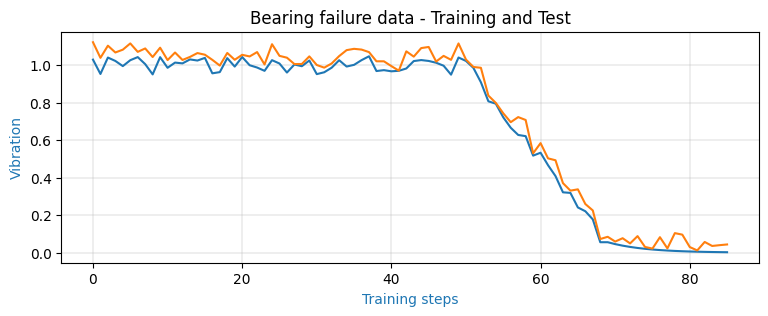

In [122]:
BEARING_DATA = 'BearingData_Training.csv'
TEST_DATA = 'BearingData_Test.csv'

df = pd.read_csv(BEARING_DATA)
train_data = df[["vibration"]].values.astype('float32')

df = pd.read_csv(TEST_DATA)
test_data = df[["vibration"]].values.astype('float32')

data = [train_data, test_data]
plot_data(data, 'Bearing failure data - Training and Test', 'Vibration')

In [123]:
# train-test split for time series
train_size = len(train_data)
test_size = len(test_data)

In [138]:
lookback = 4
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(test_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([82, 4, 1]) torch.Size([82, 4, 1])
torch.Size([82, 4, 1]) torch.Size([82, 4, 1])


The output of nn.LSTM() is a tuple. The first element is the generated hidden states, one for each time step of the input. The second element is the LSTM cell’s memory and hidden states, which is not used here

In [125]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
        self.linear = nn.Linear(128, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [209]:
lstm_model = LSTMModel()
optimizer = _T_optim.Adam(lstm_model.parameters())
loss_fn = nn.MSELoss()
loader = _T_data.DataLoader(_T_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 200
for epoch in range(n_epochs):
    lstm_model.train()
    for X_batch, y_batch in loader:
        y_pred = lstm_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    lstm_model.eval()
    with T.no_grad():
        y_pred = lstm_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = lstm_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.6474, test RMSE 0.6828
Epoch 10: train RMSE 0.1971, test RMSE 0.2069
Epoch 20: train RMSE 0.1094, test RMSE 0.1140
Epoch 30: train RMSE 0.0849, test RMSE 0.0886
Epoch 40: train RMSE 0.0693, test RMSE 0.0740
Epoch 50: train RMSE 0.0568, test RMSE 0.0627
Epoch 60: train RMSE 0.0480, test RMSE 0.0565
Epoch 70: train RMSE 0.0427, test RMSE 0.0522
Epoch 80: train RMSE 0.0410, test RMSE 0.0518
Epoch 90: train RMSE 0.0402, test RMSE 0.0510
Epoch 100: train RMSE 0.0415, test RMSE 0.0510
Epoch 110: train RMSE 0.0402, test RMSE 0.0505
Epoch 120: train RMSE 0.0404, test RMSE 0.0521
Epoch 130: train RMSE 0.0397, test RMSE 0.0504
Epoch 140: train RMSE 0.0398, test RMSE 0.0503
Epoch 150: train RMSE 0.0407, test RMSE 0.0527
Epoch 160: train RMSE 0.0411, test RMSE 0.0531
Epoch 170: train RMSE 0.0439, test RMSE 0.0518
Epoch 180: train RMSE 0.0411, test RMSE 0.0502
Epoch 190: train RMSE 0.0397, test RMSE 0.0512


In [210]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_pred.shape)

torch.Size([82, 4, 1])
torch.Size([82, 4, 1])
torch.Size([82, 4, 1])
torch.Size([82, 4, 1])
torch.Size([2, 4, 1])


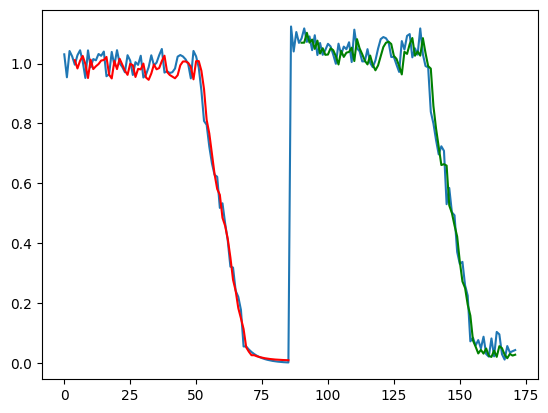

In [148]:
timeseries = [*train_data, *test_data]
with T.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = lstm_model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = lstm_model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = lstm_model(X_test)[:, -1, :]

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()